# Exploratory Data Analysis of Images

In [1]:
import warnings
from myst_nb import glue
from bcd.explore.image.eda_image import ImageExplorer
warnings.filterwarnings("ignore")

Image quality factors such as resolution, the presence of noise and artifacts, contrast, and size affect the visual information contained in mammography, and crucially determine the performance of deep learning classification models.

In this section, we conduct an exploratory data analysis of the CBIS-DDSM full mammogram imaging data with several objectives in mind:

1. Evaluate image quality in terms of noise, annotations, artifacts, and labeling that may negatively affect the classification task.
2. Inspect the distribution of image resolution and aspect ratios.
3. Examine pixel intensity distributions by class.
4. Visually characterize image texture and contrast vis-a-vis case pathology, abnormality type, and BI-RADS assessment.

## Summary
There are 3565 full mammogram images, not counting one for which the DICOM file was corrupt. {numref}`edai_summary_fig` shows the the number of images in the training and test sets by pathology.

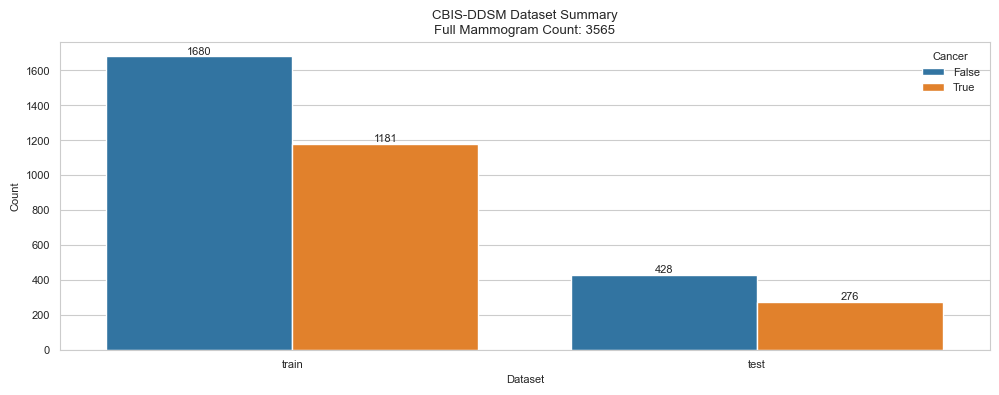

In [2]:
x = ImageExplorer()
_, stats = x.summary()

In [3]:
stats

,Benign,% Benign,Malignant,% Malignant,Total,Split
Dataset,,,,,,
train,1680,59,1181,41,2861,0.80
test,428,61,276,39,704,0.20


As show in {numref}`eda_summary_fig` and {numref}`edai_summary_table`, we have a training test split of 80/20 where malignancy was found in approximately 40% of the cases. 

Class imbalance can lead to biased predictions. Augmenting the malignant class with various transformations will mitigate bias induced by class imbalance.

## Resolution and Aspect Ratio
Optimal resolution is essential to distinguish malignancy in subtle radiological masses and calcifications. {numref}`edai_resolution_fig` illuminates the distribution of resolution in the CBIS-DDSM dataset.

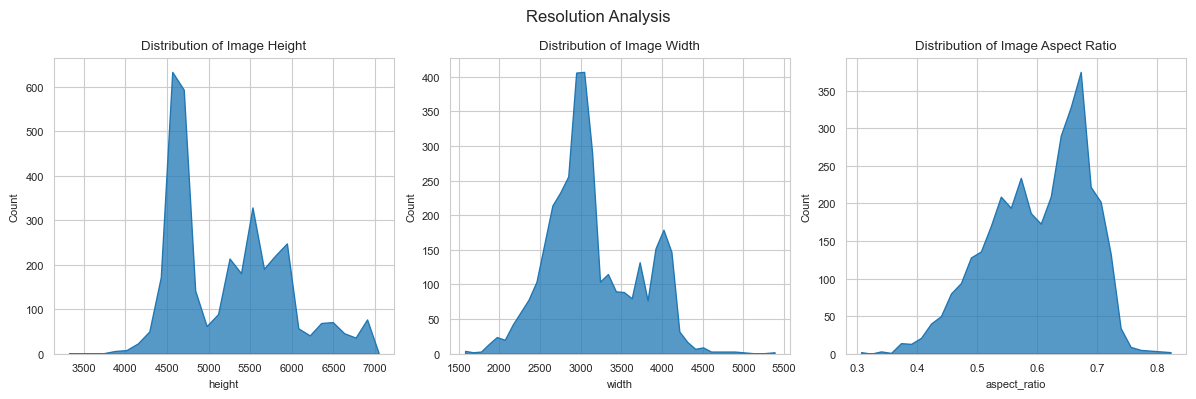

In [4]:
_, stats = x.analyze_resolution()

In [5]:
stats

,count,mean,std,min,25%,50%,75%,max
height,"3,565.00","5,220.81",671.22,"3,256.00","4,632.00","5,191.00","5,720.00","7,111.00"
width,"3,565.00","3,138.21",556.19,"1,531.00","2,776.00","3,040.00","3,536.00","5,431.00"
aspect_ratio,"3,565.00",0.60,0.08,0.30,0.54,0.62,0.67,0.83


{numref}`edia_resolution_fig` and {numref}`edia_resolution_stats` indicate high resolution images with heights ranging from 3256 to 7111 pixels, and widths of 1531 to 5431 pixels. The mean aspect ratio is 0.6, and ranges from 0.3 to 0.83. 

Images will be resized to 256x256 for the convolutional neural network model. Generally, there are two approaches to resizing:
- **Destructive Resizing**: Image is resized without retaining the original aspect ratio.
- **Non-Destructive Resizing**: Images are resized with padding to retain the original aspect ratio.

We will be experimenting with both methods to determine which results in higher classification accuracy, and recall. 

## Pixel Value Distribution
Pixel intensity value is the property that defines the spatial characteristics of the breast and abnormalities in mammography. Here, we examine the centrality and variation (standard deviation) of pixel values for benign and malignant cases.

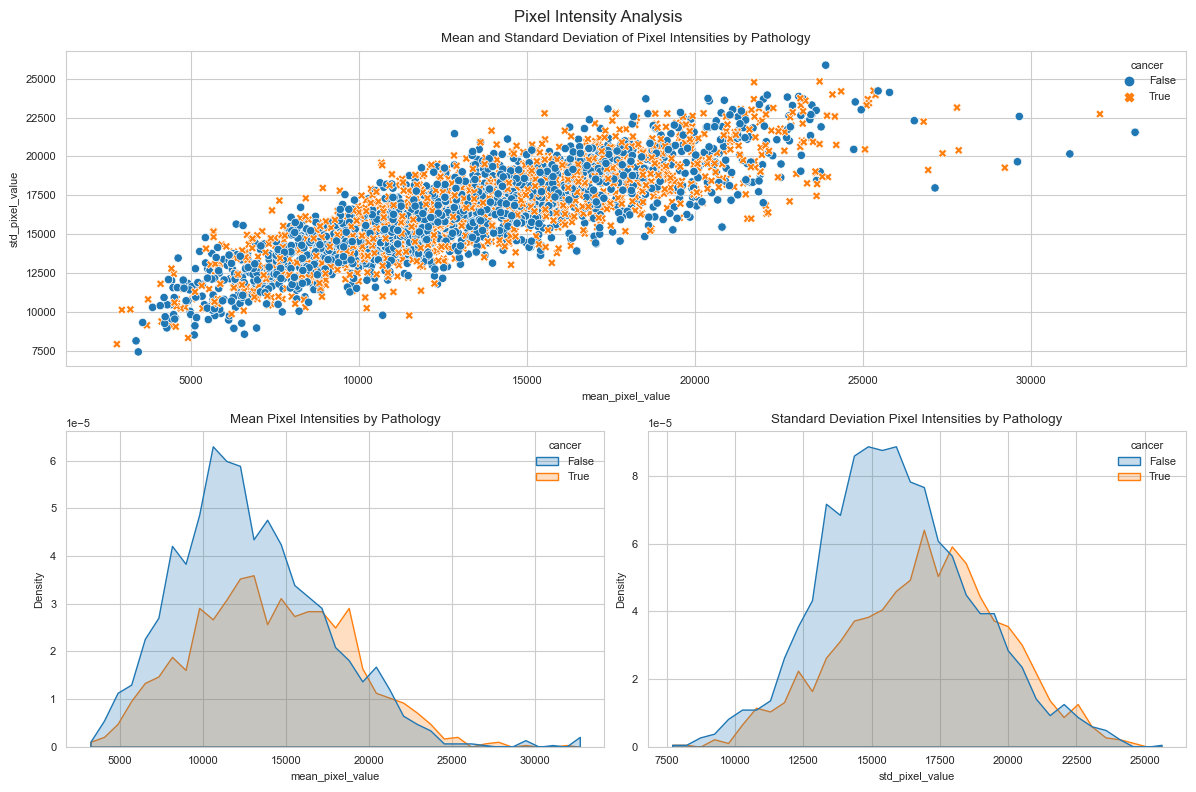

In [6]:
_, stats = x.analyze_pixel_values()

In [7]:
stats

mean_pixel_value                                                  \
                  count      mean      std      min       25%       50%   
cancer                                                                    
False          2,108.00 12,762.52 4,436.66 3,377.76  9,701.53 12,151.25   
True           1,457.00 14,025.57 4,620.74 2,807.01 10,701.68 13,855.93   

                           std_pixel_value                              \
             75%       max           count      mean      std      min   
cancer                                                                   
False  15,459.33 33,101.72        2,108.00 15,929.06 2,786.22 7,435.59   
True   17,371.88 32,054.81        1,457.00 16,877.45 2,917.67 7,932.51   

                                                
             25%       50%       75%       max  
cancer                                          
False  14,003.15 15,746.15 17,712.00 25,870.71  
True   14,858.65 17,014.15 18,850.75 24,824.86

Several observations can be made based upon {numref}`edai_pixels_fig` and {numref}`edai_pixels_stats`:

1. Standard deviation and mean appear to be positively and linearly associated.  
2. Though from a statistical perspective, outliers are extant at 3 * the standard deviation from the average mean, the maximum values are approximately half of the maximum pixel value for 16-bit images. 
3. Malignant cases tend to have slightly higher averages and greater variation in pixel intensities.

Is the difference in average mean pixel intensities between classes significant? 

In [8]:
cond_benign = lambda x: x['cancer'] == False
cond_malignant = lambda x: x['cancer'] == True
benign_pixels_averages = x.get_data(x='mean_pixel_value', condition=cond_benign)
malignant_pixels_averages = x.get_data(x='mean_pixel_value', condition=cond_malignant)
t, pvalue = x.test_centrality(a=benign_pixels_averages, b=malignant_pixels_averages, alternative='less')
df = len(benign_pixels_averages) + len(malignant_pixels_averages) - 2

A student's t-test reveals that the average mean intensity values for the benign cases (M=12,762.52, SD=4,436.66) were less than average mean pixel values for the malignant cases (M=14,025.57, SD=4620.74); t(3563)=-8.15, p < 0.01

Overall, the pixel value analysis revealed no data quality issues.

## Image Quality Analysis
Here, we examine the quality of the mammography in terms of artifacts, text, and other anomalies that may influence the classification task.

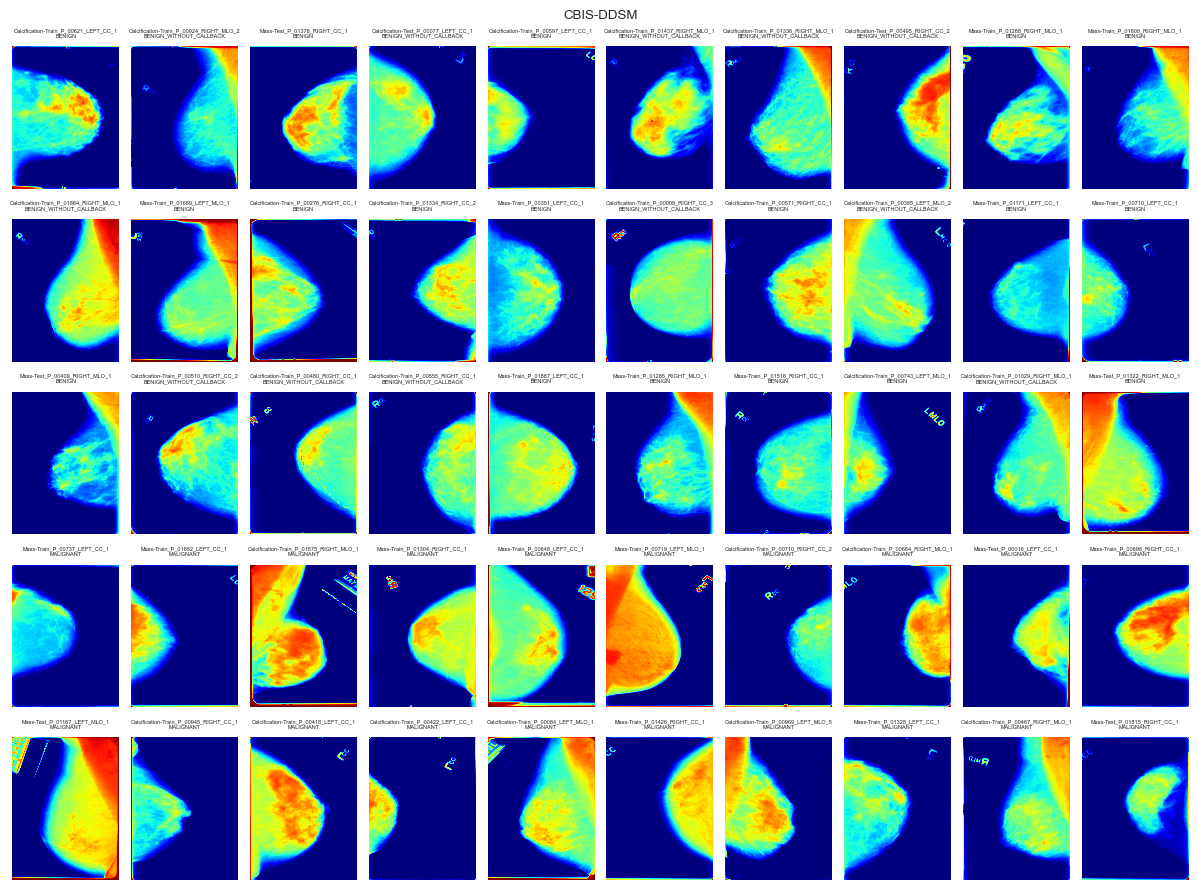

In [9]:
fig = x.visualize(n=50, sort_by='cancer', random_state=5)

{numref}`edai_dqa` shows a random sampling of 50 mammogram images from the CBIS-DDSM. We make note of the following:

1. Artifacts and/or lines were found in 44 out of 50 (88%) images. 
2. Pectoral muscle, evident in 19 (38%) of the images in the sample, have similar density and pixel intensity values as the dense tissues of interest. Image preprocessing must identify and remove both artifacts, and pectoral muscles from the images.
3. The first three rows contain mammograms showing benign diagnoses and the last two rows show malignancies. Generally, malignancies are characterized by high density and high contrast in the regions of interest.

Next, we examine images by abnormality type.

## Calcification Case Analysis
Diagnosing breast calcifications involves analyzing the morphology and distribution of calcifications. Here, we examine the following top five calcification morphologies in the CBIS-DDSM dataset.
1. 

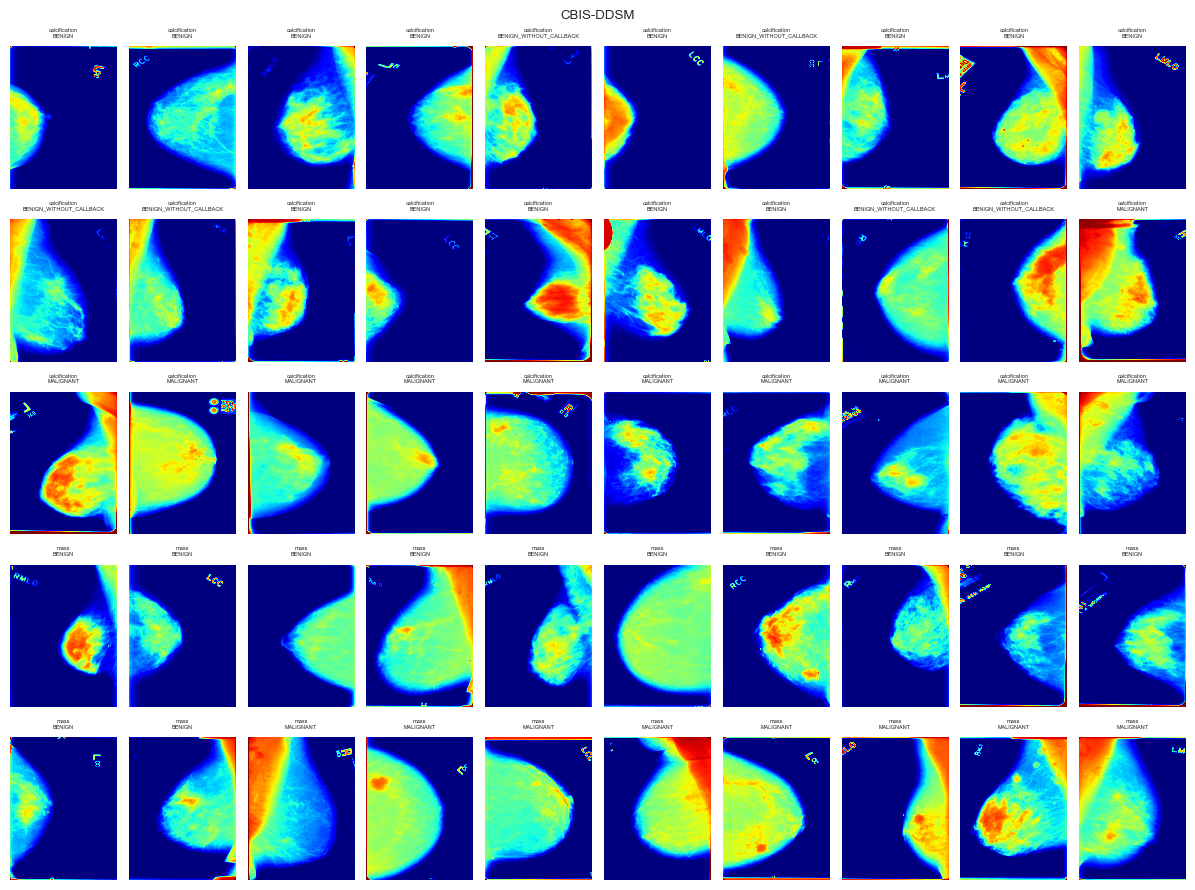

In [10]:
fig = x.visualize(n=50, sort_by=['abnormality_type', 'cancer'], label='abnormality_type', random_state=10)

## Calcification Case Analysis
Diagnosing breast calcifications involves analyzing the morphology and distribution of calcifications. Here, we examine the most common calcification morphologies and distributions in the CBIS-DDSM dataset.

### Calcification Morphology 
Morphology defines the form of calcifications.  It is the most important factor in differentiating between benign and malignant calcifications. Here, we examine the most common calcification morphologies in the CBIS-DDSM dataset.
```{table} Calcification Morphologies
| Morphology            | BI-RADS   Assessment                                   |
|-----------------------|--------------------------------------------------------|
| Lucent Centered       | BI-RADS 2 - Benign                                     |
| Punctate              | BI-RADS 2,3,4 - Benign / Probably   Benign / Suspicous |
| Pleomorphic           | BI-RADS 4 - Suspicous                                  |
| Amorphous             | BI-RADS 4 - Suspicous                                  |
| Fine Linear Branching | BI-RADS 4C - Highly Suspicious                         |
```


#### Lucent-Centered
Lucent-Centered calcifications are round or oval, ranging from 1mm to over a centimeter. They are the result of fat necrosis, calcified debris in ducts, and occasional fibroadenomas. Lucent-centered calcifications are assessed as BI-RADS 2 – Benign {cite}`smithuisRadiologyAssistantDifferential`.

## 

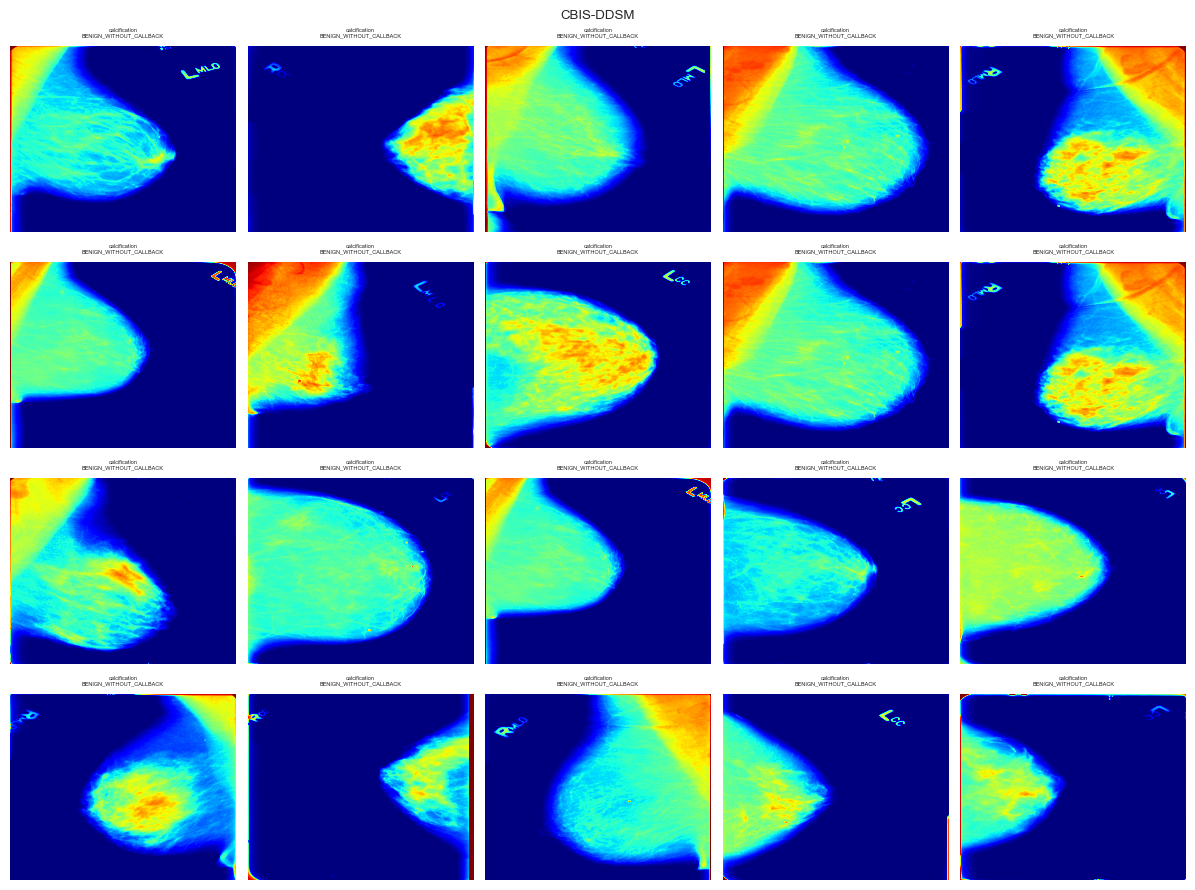

In [12]:
cond = lambda x: x['calc_type'].isin(['LUCENT_CENTERED', 'LUCENT_CENTERED_PUNCTATE'])
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], label='abnormality_type', random_state=20)

#### Punctate
Punctate morphology refers to round calcifications smaller than 0.5mm that frequently form in the acini of the terminal duct lobular unit. Round and punctate calcifications are classified as 
-	BI-RADS 2: when scattered round calcifications
-	BI-RADS 3 or 4: when in an isolated cluster


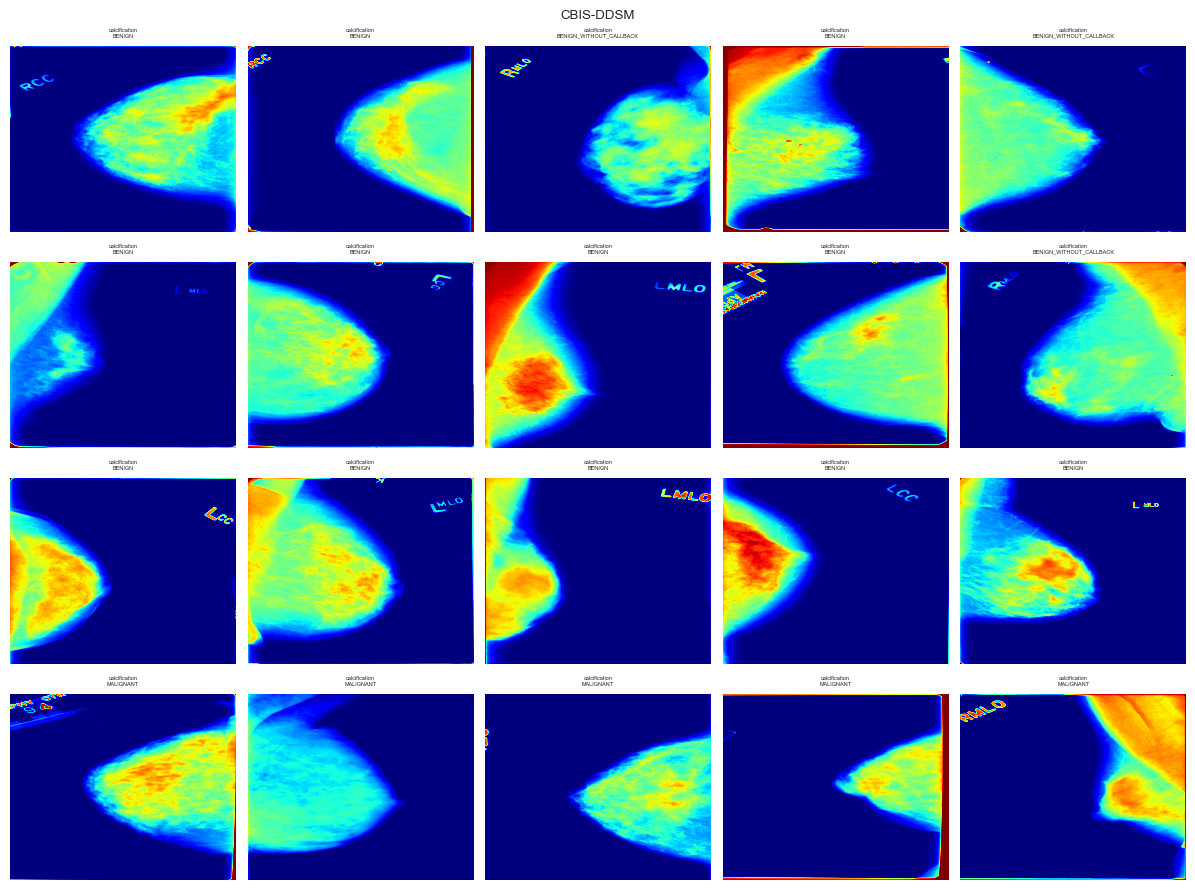

In [13]:
cond = lambda x: x['calc_type'] == 'PUNCTATE'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], label='abnormality_type', random_state=20)

#### Pleomorphic
Pleomorphic calcifications vary in size and shape but are usually smaller than 0.5 mm in diameter. They represent a 25%-40% chance of malignancy. 

In [ ]:
cond = lambda x: x['calc_type'] == 'PLEOMORPHIC'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], label='abnormality_type', random_state=20)

#### Amorphous
Amorphous calcifications are defined as ‘without clearly defined shape or form’. They are typically small and/or hazy in appearance. The majority of cases are benign (60%), with the remainder of cases presenting as high-risk (20%) or malignant (20%) {cite}`smithuisRadiologyAssistantDifferential`. 


In [ ]:
cond = lambda x: x['calc_type'] == 'AMORPHOUS'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], label='abnormality_type', random_state=20)

#### Fine Linear Branching
These are thin, irregular, linear, or curvilinear calcifications and are highly suspicious (BI-RADS-4C). 


In [ ]:
cond = lambda x: x['calc_type'] == 'FINE_LINEAR_BRANCHING'
fig = x.visualize(n=20, condition=cond, sort_by=['cancer'], label='abnormality_type', random_state=20)

### Calcification Distribution